# Bayesian Optimisation Ray Tune
- This file performs hyperparameter optimization using Bayesian Optimization with the HyperBand scheduler from Ray Tune.
- It integrates a Vision Transformer model, optimizing over a manually defined configuration space using ConfigSpace.

In [1]:
"""
This file performs hyperparameter optimization using Bayesian Optimization with the HyperBand scheduler from Ray Tune.
It integrates a Vision Transformer model, optimizing over a manually defined configuration space using ConfigSpace.
"""

import os
from datetime import datetime
import logging
import ConfigSpace as CS
from ConfigSpace.conditions import EqualsCondition, OrConjunction
import ray
from ray import tune
from ray.tune import Tuner, TuneConfig, with_resources
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
import torch.nn.functional as F

In [2]:
CLASSES = 3
DATA_DIR = "/home/sur06423/wacv_paper/wacv_paper/data/pizza_steak_sushi"

In [3]:
# Setup logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s", handlers=[
    logging.FileHandler(f"hyperopt_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"),
    logging.StreamHandler()
])


In [4]:
class VisionTransformerModel:
    """Encapsulates the Vision Transformer model setup."""
    
    @staticmethod
    def define_model(use_gpu, num_classes=CLASSES):
        """Configures a Vision Transformer for image classification with a frozen backbone.
        
        Args:
            use_gpu (bool): Whether to utilize CUDA if available.
            num_classes (int): The number of classes for the output layer.

        Returns:
            Tuple[torch.nn.Module, torchvision.transforms]: Configured model and associated transforms.
        """
        pretrained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
        model = torchvision.models.vit_b_16(weights=pretrained_weights)
        for param in model.parameters():
            param.requires_grad = False
        model.heads = nn.Linear(in_features=768, out_features=num_classes)
        return model, pretrained_weights.transforms()

In [5]:
class DataLoaderFactory:
    """Handles the creation of dataset loaders for training and validation."""

    @staticmethod
    def get_data_loaders(transform, batch_size=256):
        """Creates training and validation data loaders.

        Args:
            transform (callable): A function/transform that takes in a PIL image and returns a transformed version.
            batch_size (int): Number of images in each batch of data.

        Returns:
            Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]: Data loaders for training and validation.
        """
        train_dataset = ImageFolder(root=os.path.join(DATA_DIR, "train"), transform=transform)
        val_dataset = ImageFolder(root=os.path.join(DATA_DIR, "test"), transform=transform)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        return train_loader, val_loader

In [6]:
class Metrics:
    """Provides methods to calculate evaluation metrics for model performance."""
    
    @staticmethod
    def calculate_balanced_accuracy(y_pred, y_true, num_classes=CLASSES):
        """Calculates the balanced accuracy across given predictions and true labels.

        Args:
            y_pred (torch.Tensor): Predictions from the model.
            y_true (torch.Tensor): Actual labels from the dataset.
            num_classes (int): Number of different classes in the dataset.

        Returns:
            float: Balanced accuracy score.
        """
        correct_per_class = torch.zeros(num_classes, device=y_pred.device)
        total_per_class = torch.zeros(num_classes, device=y_pred.device)
        for c in range(num_classes):
            true_positives = ((y_pred == c) & (y_true == c)).sum()
            condition_positives = (y_true == c).sum()
            correct_per_class[c] = true_positives.float()
            total_per_class[c] = condition_positives.float()
        recall_per_class = correct_per_class / total_per_class.clamp(min=1)
        return recall_per_class.mean().item()

In [7]:
def create_fine_tuning_config_space():
    """Creates a configuration space for fine-tuning the Vision Transformer using ConfigSpace."""
    config_space = CS.ConfigurationSpace()

    # Define main hyperparameters
    optimizer = CS.CategoricalHyperparameter("optimizer", ["SGD", "Adam", "AdamW"])
    learning_rate = CS.UniformFloatHyperparameter("learning_rate", lower=1e-5, upper=1e-2, log=True)
    weight_decay = CS.UniformFloatHyperparameter("weight_decay", lower=1e-6, upper=1e-3, log=True)
    momentum = CS.UniformFloatHyperparameter("momentum", lower=0.5, upper=0.99)
    scheduler = CS.CategoricalHyperparameter("scheduler", ["StepLR", "CosineAnnealing", "ExponentialLR", "LinearLR"])
    step_size = CS.CategoricalHyperparameter("step_size", [5, 10, 15])
    gamma = CS.UniformFloatHyperparameter("gamma", lower=0.1, upper=0.9)
    T_max = CS.CategoricalHyperparameter("T_max", [10, 20, 30])
    eta_min = CS.Constant("eta_min", 1e-6)
    start_lr = CS.Constant("start_lr", None)  # Can be set relative to learning_rate
    end_lr = CS.Constant("end_lr", 1e-6)
    epochs = CS.CategoricalHyperparameter("epochs", [10, 20, 30, 40, 50])
    use_gpu = CS.CategoricalHyperparameter("use_gpu", [True])  # Explicitly set use_gpu

    # Add all hyperparameters to the configuration space
    config_space.add([
        optimizer, learning_rate, weight_decay, momentum, scheduler,
        step_size, gamma, T_max, eta_min, start_lr, end_lr, epochs, use_gpu
    ])

    # Add conditions for conditional hyperparameters
    momentum_condition = EqualsCondition(momentum, optimizer, "SGD")
    step_size_condition = EqualsCondition(step_size, scheduler, "StepLR")
    
    # Combine conditions for gamma using OrConjunction
    gamma_condition = OrConjunction(
        EqualsCondition(gamma, scheduler, "StepLR"),
        EqualsCondition(gamma, scheduler, "ExponentialLR")
    )
    
    T_max_condition = EqualsCondition(T_max, scheduler, "CosineAnnealing")
    eta_min_condition = EqualsCondition(eta_min, scheduler, "CosineAnnealing")
    end_lr_condition = EqualsCondition(end_lr, scheduler, "LinearLR")

    # Add all conditions to the configuration space
    config_space.add([
        momentum_condition, step_size_condition, gamma_condition,
        T_max_condition, eta_min_condition, end_lr_condition
    ])

    return config_space

In [8]:
class TrainViT(tune.Trainable):
    """A trainable class for Ray Tune that handles the training and validation of a Vision Transformer model."""
    
    def setup(self, config):
        """Prepares the model, data loaders, optimizer, and scheduler for training based on the configuration provided.

        Args:
            config (dict): Configuration dictionary containing hyperparameters and model settings.
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() and config["use_gpu"] else "cpu")
        self.model, transforms = VisionTransformerModel.define_model(config["use_gpu"])
        self.model.to(self.device)
        self.train_loader, self.val_loader = DataLoaderFactory.get_data_loaders(transforms)
        self.optimizer = self._initialize_optimizer(config)
        self.scheduler = self._initialize_scheduler(config)

    def _initialize_optimizer(self, config):
        """Initializes the optimizer based on the configuration.

        Args:
            config (dict): Configuration dictionary specifying the optimizer type and parameters.

        Returns:
            torch.optim.Optimizer: Initialized optimizer.
        """
        if config["optimizer"] == "SGD":
            return optim.SGD(
                self.model.parameters(),
                lr=config["learning_rate"],
                momentum=config["momentum"],
                weight_decay=config["weight_decay"]
            )
        elif config["optimizer"] == "Adam":
            return optim.Adam(
                self.model.parameters(),
                lr=config["learning_rate"],
                weight_decay=config["weight_decay"]
            )
        elif config["optimizer"] == "AdamW":
            return optim.AdamW(
                self.model.parameters(),
                lr=config["learning_rate"],
                weight_decay=config["weight_decay"]
            )

    def _initialize_scheduler(self, config):
        """Initializes the learning rate scheduler based on the configuration.

        Args:
            config (dict): Configuration dictionary specifying the scheduler type and parameters.

        Returns:
            Optional[torch.optim.lr_scheduler._LRScheduler]: Initialized scheduler, or None if not applicable.
        """
        if config["scheduler"] == "StepLR":
            return optim.lr_scheduler.StepLR(self.optimizer, step_size=config["step_size"], gamma=config["gamma"])
        elif config["scheduler"] == "CosineAnnealing":
            return optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=config["T_max"], eta_min=config["eta_min"])
        elif config["scheduler"] == "ExponentialLR":
            return optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=config["gamma"])
        elif config["scheduler"] == "LinearLR":
            # If start_lr is None, use learning_rate from the optimizer
            start_factor = 1.0 if config["start_lr"] is None else config["start_lr"] / config["learning_rate"]
            return optim.lr_scheduler.LinearLR(self.optimizer, start_factor=start_factor, end_factor=config["end_lr"] / config["learning_rate"])

    def step(self):
        """Executes a single step of training and validation.

        Returns:
            dict: A dictionary containing training and validation loss and accuracy.
        """
        train_loss, train_acc = self._train_one_epoch()
        if self.scheduler:
            self.scheduler.step()

        # Get the current learning rate
        current_lr = self.optimizer.param_groups[0]['lr']

        val_loss, val_acc = self._validate_one_epoch()
        return {"loss": train_loss, "accuracy": train_acc, "val_loss": val_loss, "val_acc": val_acc, "learning_rate": current_lr}

    def _train_one_epoch(self):
        """Conducts a single epoch of training on the entire training dataset.

        Returns:
            Tuple[float, float]: Training loss and Balanced accuracy.
        """
        self.model.train()
        running_loss = 0.0
        all_predictions, all_labels = [], []
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            all_predictions.append(torch.argmax(torch.softmax(outputs, dim=1), dim=1))
            all_labels.append(labels)
        avg_loss = running_loss / len(self.train_loader.dataset)
        balanced_acc = Metrics.calculate_balanced_accuracy(torch.cat(all_predictions), torch.cat(all_labels))
        return avg_loss, balanced_acc

    def _validate_one_epoch(self):
        """Conducts validation on the entire validation dataset and computes loss and accuracy.

        Returns:
            Tuple[float, float]: Validation loss and Balanced accuracy.
        """
        self.model.eval()
        running_loss = 0.0
        all_predictions, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = F.cross_entropy(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                all_predictions.append(torch.argmax(torch.softmax(outputs, dim=1), dim=1))
                all_labels.append(labels)
        avg_loss = running_loss / len(self.val_loader.dataset)
        balanced_acc = Metrics.calculate_balanced_accuracy(torch.cat(all_predictions), torch.cat(all_labels))
        return avg_loss, balanced_acc

    def save_checkpoint(self, checkpoint_dir):
        """Saves the current model and optimizer state to a checkpoint.

        Args:
            checkpoint_dir (str): Directory path to save the checkpoint.

        Returns:
            str: Path to the checkpoint directory.
        """
        checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")
        torch.save({
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
        }, checkpoint_path)
        return checkpoint_dir

    def load_checkpoint(self, checkpoint_dir):
        """Loads the model and optimizer state from a checkpoint.

        Args:
            checkpoint_dir (str): Directory path from which to load the checkpoint.
        """
        checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [9]:
def setup_library_paths():
    """Configures additional library paths required for GPU computation.
        Note: These paths are specific to my local server.
              You might not need to define them.
        
        Adds specified library paths to the LD_LIBRARY_PATH environment variable
        if they are not already included, ensuring GPU dependencies are located.
    """
    library_paths = [
        "/usr/lib/xorg-nvidia-525.116.04/lib/x86_64-linux-gnu",
        "/usr/lib/xorg/lib/x86_64-linux-gnu",
        "/usr/lib/xorg-nvidia-535.113.01/lib/x86_64-linux-gnu"
    ]
    current_ld_library_path = os.environ.get('LD_LIBRARY_PATH', '')
    new_paths = [path for path in library_paths if path not in current_ld_library_path]
    os.environ['LD_LIBRARY_PATH'] = ':'.join(new_paths + [current_ld_library_path])
    print("Updated LD_LIBRARY_PATH:")
    print(os.environ['LD_LIBRARY_PATH'])

In [10]:
def main():
    """Main function to set up and execute the hyperparameter tuning."""
    ray.shutdown()
    ray.init(num_cpus=40, num_gpus=4, include_dashboard=True)
    setup_library_paths()

    # Create the ConfigSpace
    config_space = create_fine_tuning_config_space()

    # Set the max_t to the maximum possible number of epochs from the hyperparameter space
    max_epochs = max(config_space.get_hyperparameter("epochs").choices)

    # Create the HyperBandForBOHB scheduler with the max_t parameter set to max_epochs
    bohb_hyperband = HyperBandForBOHB(time_attr="training_iteration", max_t=max_epochs, reduction_factor=2, stop_last_trials=False)

    # Create the TuneBOHB search algorithm
    bohb_search = TuneBOHB(config_space, metric="val_acc", mode="max")
    bohb_search = tune.search.ConcurrencyLimiter(bohb_search, max_concurrent=4)

    # Update the RunConfig to stop based on the dynamically adjusted epochs
    run_config = ray.train.RunConfig(
        name="Bayesian_Trial_Exp_0",
        storage_path="/home/sur06423/wacv_paper/wacv_paper/ray_results",
        stop={"training_iteration": max_epochs},
        checkpoint_config=ray.train.CheckpointConfig(checkpoint_frequency=1, checkpoint_at_end=True)
    )

    # Run the Tuner with the updated configuration
    tuner = Tuner(
        trainable=with_resources(
            TrainViT,
            resources=lambda config: {"gpu": 1, "cpu": 3} if config.get("use_gpu", False) else {"cpu": 3}
        ),
        param_space={},  # Leave param_space empty as TuneBOHB uses config_space
        tune_config=TuneConfig(
            metric="val_acc",
            mode="max",
            scheduler=bohb_hyperband,
            search_alg=bohb_search,
            num_samples=100
        ),
        run_config=run_config
    )

    results = tuner.fit()
    best_result = results.get_best_result(metric="val_acc", mode="max")
    logging.info("Best trial config: {}".format(best_result.config))
    logging.info("Best trial final validation accuracy: {}".format(best_result.metrics["val_acc"]))

    ray.shutdown()


In [11]:
main()

(TrainViT pid=2112237) /home/sur06423/miniconda3/envs/deepl/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1704987280714/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
(TrainViT pid=2112237)   return F.conv2d(input, weight, bias, self.stride,
(TrainViT pid=2113196) /home/sur06423/miniconda3/envs/deepl/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1704987280714/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
(TrainViT pid=2113196)   return F.conv2d(input, weight, bias, self.stride,
(TrainViT pid=2113303) /home/sur06423/miniconda3/envs/deepl/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1704987

Combined DataFrame:
       loss  accuracy  val_loss   val_acc  learning_rate   done  \
0  0.880565  0.647111  0.562884  0.873333       0.000603  False   
1  0.469704  0.893778  0.307973  0.936000       0.000602  False   
0  0.745100  0.785333  0.446155  0.932000       0.000620  False   
1  0.393709  0.922667  0.245815  0.954667       0.000605  False   
0  0.669711  0.743111  0.229385  0.946667       0.001573  False   

   training_iteration  trial_id                 date   timestamp  ...  \
0                   1  78515b02  2024-11-02_13-24-22  1730550262  ...   
1                   2  78515b02  2024-11-02_13-31-08  1730550668  ...   
0                   1  dd7165ce  2024-11-02_13-24-30  1730550270  ...   
1                   2  dd7165ce  2024-11-02_13-31-51  1730550711  ...   
0                   1  771912d1  2024-11-02_13-24-38  1730550278  ...   

   config/scheduler  config/start_lr  config/use_gpu config/weight_decay  \
0   CosineAnnealing             None            True          

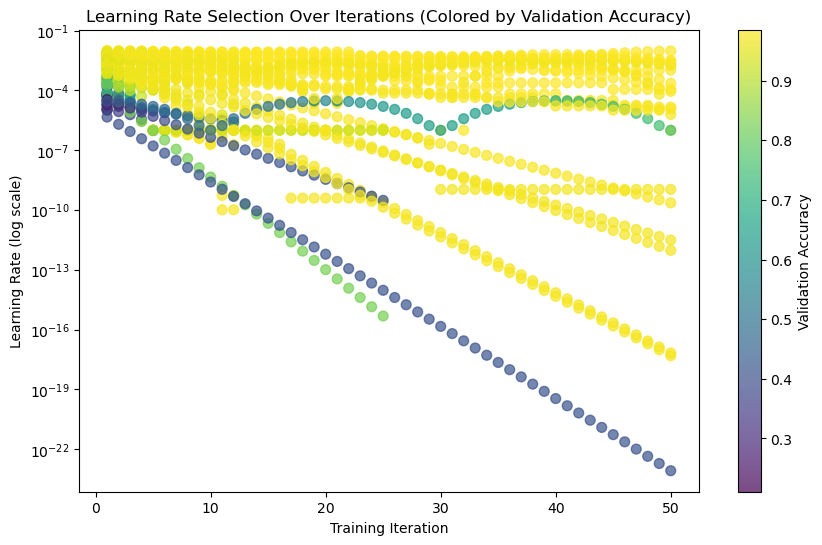

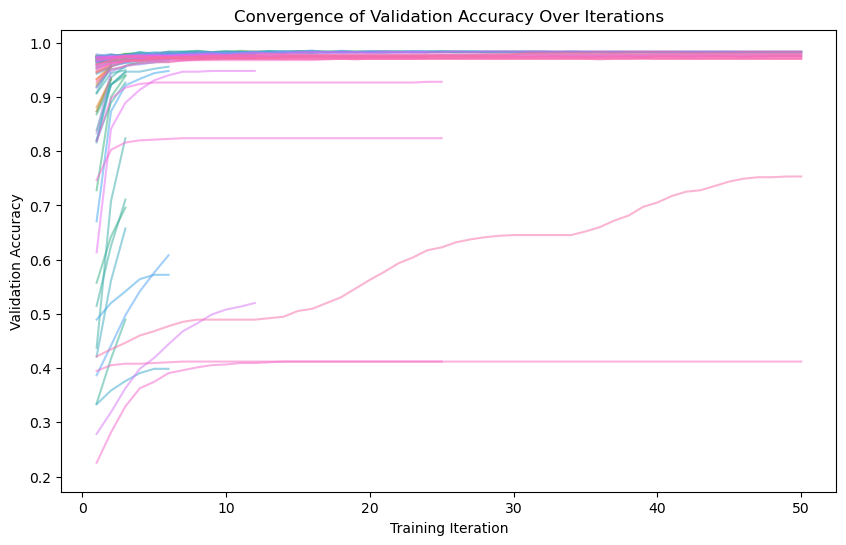

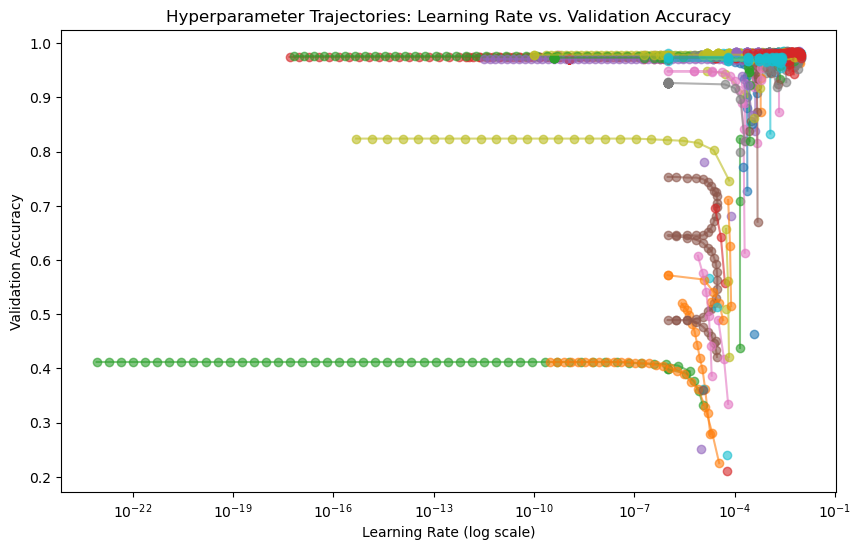

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ray.tune import ExperimentAnalysis

def analyze_bohb_results():
    # Load the experiment analysis
    analysis = ExperimentAnalysis("/home/sur06423/wacv_paper/wacv_paper/ray_results/Bayesian_Trial_Exp_0/")

    # Combine all trial data into a single DataFrame
    df = pd.concat([df for df in analysis.trial_dataframes.values()])

    # Display the first few rows of the combined DataFrame
    print("Combined DataFrame:")
    print(df.head())

    # Plot: Learning Rate vs. Validation Accuracy Over Iterations
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        df["training_iteration"],
        df["learning_rate"],
        c=df["val_acc"],
        cmap="viridis",
        s=50,
        alpha=0.7
    )
    plt.title("Learning Rate Selection Over Iterations (Colored by Validation Accuracy)")
    plt.xlabel("Training Iteration")
    plt.ylabel("Learning Rate (log scale)")
    plt.yscale("log")
    plt.colorbar(scatter, label="Validation Accuracy")
    plt.show()

    # Plot: Convergence of Validation Accuracy Over Iterations
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="training_iteration", y="val_acc", hue="trial_id", alpha=0.5, legend=None)
    plt.title("Convergence of Validation Accuracy Over Iterations")
    plt.xlabel("Training Iteration")
    plt.ylabel("Validation Accuracy")
    plt.show()

    # Plot: Hyperparameter Trajectories (Learning Rate and Validation Accuracy)
    plt.figure(figsize=(10, 6))
    for trial_id, trial_data in df.groupby("trial_id"):
        plt.plot(trial_data["learning_rate"], trial_data["val_acc"], marker='o', label=f"Trial {trial_id}", alpha=0.6)
    plt.xscale("log")
    plt.title("Hyperparameter Trajectories: Learning Rate vs. Validation Accuracy")
    plt.xlabel("Learning Rate (log scale)")
    plt.ylabel("Validation Accuracy")
    plt.show()

# Call the analysis function after the experiment
analyze_bohb_results()